> ### Binary CNN

In [1]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy
from collections import OrderedDict

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#### Data
<a id=unzip_dataset></a>
Download computer generated **horses and humans dataset** from Google to local subdirectories in format **as photo below**, so that [ImageDataGenerator](#imagegenerator) will be able to generate dataset from subdirectories for us automatically.

<img src="images/image_generator.png" style="width:550px;height:300px;">

In [ ]:
path = tf.keras.utils.get_file(
    fname='tmp/horse_or_human.zip', #自定义文件名
    origin='https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip', 
    extract=True) #unzip
path
path = tf.keras.utils.get_file(
    fname='tmp/horse_or_human.zip', 
    origin='https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip', 
    extract=True) #unzip
path

In [4]:
with zipfile.ZipFile('tmp/horse-or-human.zip', 'r') as f:
    f.extractall('tmp/training')
    
with zipfile.ZipFile('tmp/validation-horse-or-human.zip', 'r') as f:
    f.extractall('tmp/validation')

In [ ]:
train_dir='tmp/training'
validation_dir='tmp/validation'
train_horse_names = os.listdir(os.path.join(train_dir,'horses'))
train_human_names = os.listdir(os.path.join(train_dir,'humans'))')
validation_horse_names = os.listdir(os.path.join(validation_dir,'horses'))
validation_human_names = os.listdir(os.path.join(validation_dir,'humans'))
print(f'Training set: {len(train_horse_names)} for horses, {len(train_human_names)} for humans')
print(f'Validation set: {len(validation_horse_names)} for horses, {len(validation_human_names)} for humans')

<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

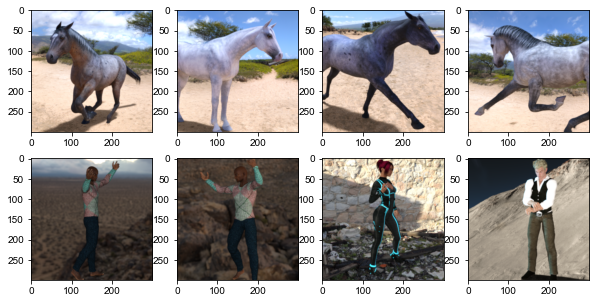

In [27]:
train_horse_path = [os.path.join('tmp/training/horses', file_name) for file_name in train_horse_names]
train_human_path = [os.path.join('tmp/training/humans', file_name) for file_name in train_human_names]
random_horse = np.random.choice(train_horse_path,4,replace=False)
random_human = np.random.choice(train_human_path,4,replace=False)

plt.figure(figsize=(8,4))
for i, path in enumerate(np.concatenate([random_horse,random_human])):
    plt.subplot(2,4,i+1)
    photo = imageio.imread(path)
    plt.axis('off')
    plt.imshow(photo);

#### Preprocessing
As training datasets might not always be well-prepared:
- all **labelled properly** in numpy or pandas format 
- all in the **target size of images** nicely 

<a id='imagegenerator'></a>
**ImageDataGenerator** can read pictures from local path, and automatically label them according to the subdirectories name. It will then convert them to float32 tensors, yield augmented image batches (and their labels), and feed them to the network. 

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255) #normalize
train_generator = train_datagen.flow_from_directory(
    train_dir, #主directory
    target_size=(300,300), #统一尺寸，好处是可以尝试不同尺寸同时，不会改变原图
    batch_size=128, #1027张图归为128张/batch，即9个batches/epoch
    class_mode='binary') #Multi-class时categorical

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(300,300), batch_size=32, class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**[Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)** is a great tool to avoid overfitting by randomly augment the images in memory that yield believable-looking images, based on photos flowing out from the directory on disk. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255, # normalize
      rotation_range=40, # 随机旋转(0–180)度
      width_shift_range=0.2, # 随机平移/垂直移高宽的相对距离
      height_shift_range=0.2, 
      shear_range=0.2, # shearing transformations逆时针剪切强度
      zoom_range=0.2, #放大
      horizontal_flip=True, #翻转
      fill_mode='nearest') #对于改变之后而产生的空白pixel，fillout的方式

train_generator = train_datagen.flow_from_directory( 
    'tmp/training/', #对于numpy dataset，直接train_datagen.flow(x_train,y_train,batch_size)
    target_size=(300,300), 
    batch_size=128, 
    class_mode='binary')

#不需要distortion，但是你也可以distort来模拟更多的情况，看模型是否能预测正确
validation_datagen = ImageDataGenerator(rescale=1./255) 
validation_generator = validation_datagen.flow_from_directory(
    'tmp/validation/', target_size=(300,300), batch_size=32, class_mode='binary')

In [ ]:
#假设已经开始训练模型后发现有overfitting，既可以重新调整数据再次训练模型，也可以利用layers来实现
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(300,300,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomFlip("horizontal")
])
augmented_images = data_augmentation(images)

#### Model

In [32]:
model = keras.Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=(300,300,3)), #RGB photo
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(32, 3, activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.Dense(1, activation='sigmoid'), #binary classification 
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [35]:
model.compile(optimizer='rmsprop', #keras.optimizers.RMSprop(learning_rate=0.001)
              loss="binary_crossentropy",
              metrics=['accuracy'])

history = model.fit(
          train_generator, #128张/batch，共9 batches/epoch才能遍历完
          steps_per_epoch=8, epochs=15, #可指定需要的batch数/epoch，不需要遍历完所有图，还有validation_steps，
          validation_data=validation_generator, validation_steps=8) #可以和steps_per_epoch不一样

Epoch 1/15
8/8 [==============================] - 62s 9s/step - loss: 1.8586 - accuracy: 0.9433 - val_loss: 1.5874 - val_accuracy: 0.8555
Epoch 2/15
8/8 [==============================] - 76s 10s/step - loss: 0.0116 - accuracy: 0.9989 - val_loss: 1.9084 - val_accuracy: 0.8516
Epoch 3/15
8/8 [==============================] - 68s 8s/step - loss: 0.0160 - accuracy: 0.9944 - val_loss: 2.1702 - val_accuracy: 0.8516
Epoch 4/15


KeyboardInterrupt: 

#### Visualize
Visualize how an input gets transformed as it goes through the convnet to get a feel for **what kind of features** our convnet has learned.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a conv layer with all filters.
The representations start from the raw pixels of the images, downstream to:
- increasingly abstract and compact representations with highlighted features 
- representation sparsity with fewer activated features, where most are set to zero
- increasingly refined information about the class of the image

In [51]:
# Get a random image from training set
random_path = np.random.choice(train_horse_path + train_human_path)
img = load_img(random_path, target_size=(300, 300))  # PIL image
x = img_to_array(img)  # Numpy array (300, 300, 3)
x = x.reshape((1,) + x.shape)  # (1, 300, 300, 3)
x /= 255 #normalize

In [38]:
# Generate a model that outputs all layers
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_names = [layer.name for layer in model.layers[1:]]
visual_model = keras.Model(inputs = model.input, outputs = layer_outputs) #output all layers output

<Figure size 2160x135 with 0 Axes>

Text(0.5, 1.0, 'max_pooling2d')

<Figure size 2160x67.5 with 0 Axes>

Text(0.5, 1.0, 'conv2d_1')

<Figure size 2160x67.5 with 0 Axes>

Text(0.5, 1.0, 'max_pooling2d_1')

<Figure size 2160x33.75 with 0 Axes>

Text(0.5, 1.0, 'conv2d_2')

<Figure size 2160x33.75 with 0 Axes>

Text(0.5, 1.0, 'max_pooling2d_2')

<ipython-input-52-78d8edbc8e47>:13: RuntimeWarning: invalid value encountered in true_divide
  x = (x-x.mean())/x.std() #standardize


<Figure size 2160x33.75 with 0 Axes>

Text(0.5, 1.0, 'conv2d_3')

<Figure size 2160x33.75 with 0 Axes>

Text(0.5, 1.0, 'max_pooling2d_3')

<Figure size 2160x33.75 with 0 Axes>

Text(0.5, 1.0, 'conv2d_4')

<Figure size 2160x33.75 with 0 Axes>

Text(0.5, 1.0, 'max_pooling2d_4')

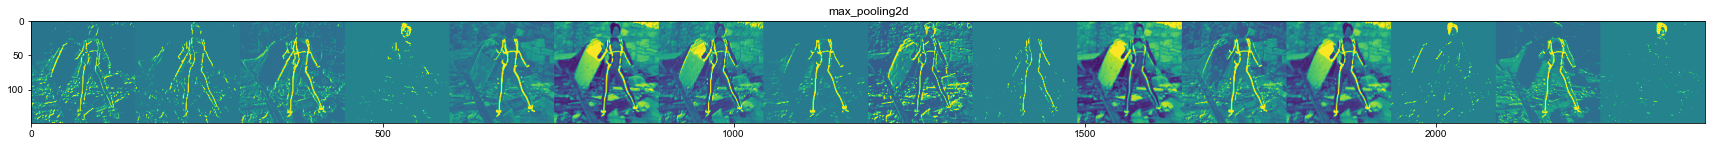

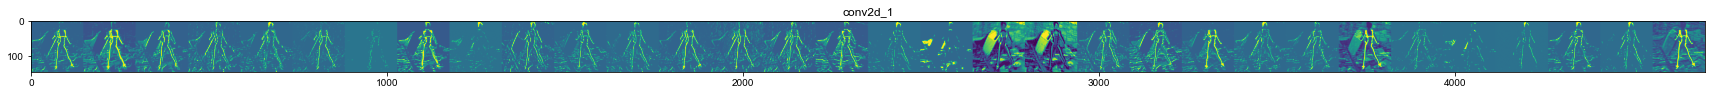

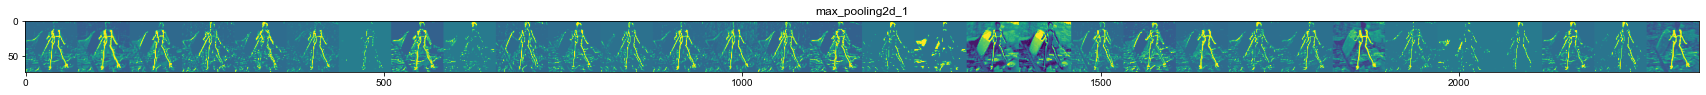

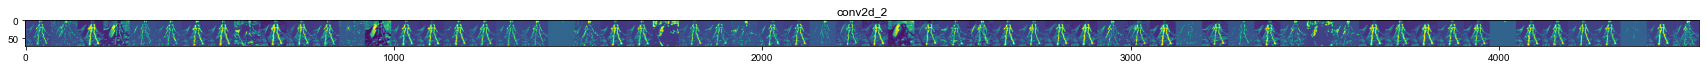

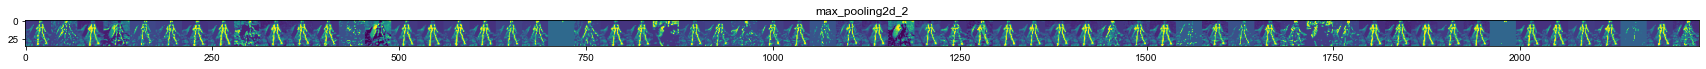

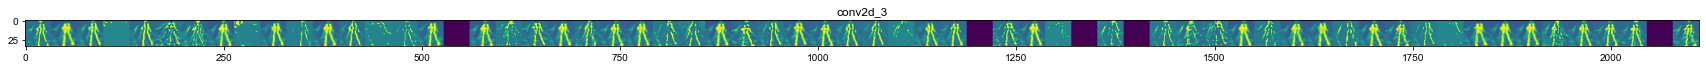

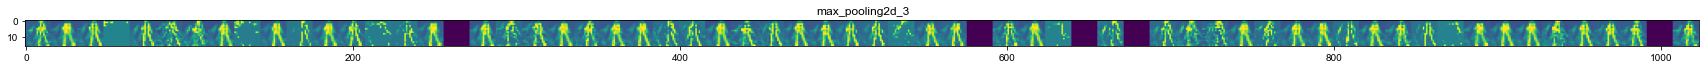

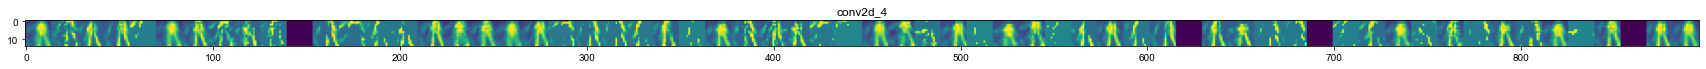

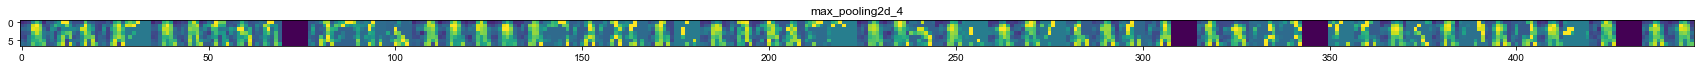

In [52]:
# Visualize all filters in all conv layers
outputs = visual_model.predict(x)
plt.imshow(img)

for layer_name, output in zip(layer_names, outputs):
    if len(output.shape) == 4: # only Conv layers (None, 26, 26, 16) 
        n_filters = output.shape[-1] 
        size = output.shape[1]
        display_grid = np.zeros([size, size * n_filters]) # one row as a photo
        
        # fill in grids
        for i in range(n_filters): 
            x = output[0, :, :, i]
            x = (x-x.mean())/x.std() #standardize x~N(0,1)
            x = x*64+128 #scale back to (0,255) when x probably within (-2,2)
            x = np.clip(x, 0, 255).astype('uint8') # clip to ensure pixel range
            display_grid[:, i*size : (i+1)*size] = x
        
        # display grids
        scale = 30. / n_filters # fixed total width for all layers
        plt.figure(figsize=(scale * n_filters, scale)) 
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

#### Prediction

In [72]:
# Preprocess the image to fit input requirement
img = load_img('tmp/WechatIMG4694.jpg', target_size=(300, 300))  # PIL image
x = img_to_array(img)  # Numpy array (300, 300, 3)
x = x.reshape((1,) + x.shape)  # (1, 300, 300, 3)，等同于x = np.array([x])
x /= 255 #normalize

In [ ]:
labels = {0:'horse',1:'human'}
y_pred = model.predict(x)
y_pred
plt.imshow(img)
plt.title(f'Predict: {labels[int(y_pred>=0.5)]}')